## Importowanie bibliotek
Biblioteka `morfeusz2` posłuży do lematyzacji, `plwordnet` i Słowosieć do analizy sentymentu. 

>**Słowosieć** (ang. PlWordNet) – baza danych leksykalno-semantycznych języka polskiego typu wordnet. Zawiera zestawy synonimicznych jednostek leksykalnych (synsety) opisanych krótkimi definicjami. Słowosieć służy jako słownik, w którym pojęcia (synsety) i poszczególne znaczenia wyrazów (jednostki leksykalne) zdefiniowane są poprzez miejsce w sieci wzajemnych relacji, odzwierciedlających system leksykalny polszczyzny. Słowosieć jest także wykorzystywana jako jeden z podstawowych zasobów do budowy programów przetwarzających język polski. ([Wikipedia](https://pl.wikipedia.org/wiki/S%C5%82owosie%C4%87))


- http://morfeusz.sgjp.pl/download/
- https://slowosiec.pl/

In [19]:
# import plwordnet
import morfeusz2
import pandas as pd
import numpy as np

In [20]:
# biblioteki do wizualizacji danych
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image

## Opis danych
Dane pochodzą z Reddita i Wykopu.
![](img/loga.png)

## Wstępne przetwarzanie tekstu
W tym punkcie podejmiemy następujące kroki:
1. Usunięcie niepotrzebnych znaków z tekstu źródłowego
2. Lematyzacja za pomocą Morfeusza
3. Usunięcie stop słów z lematów
   
Na początku załadujmy polski słownik sentymentu (ręcznie przefiltrowany `plwordnet` w csv). 

In [21]:
slownik_sentymentu = pd.read_csv('słowniki/SłownikSentymentu.csv', sep=';',encoding='cp1250')
# print(slownik_sentymentu.columns.tolist())

Wczytujemy zescrapowane pliki tekstowe z Reddita/Wykopu i dzielimy na pojedyncze słowa. Na samym końcu tworzymy ramkę danych, gdzie każde słowo jest w osobnym wierszu.

In [22]:
with open('data/results_reddit.txt', 'r', encoding='utf-8') as file:
    tekst_cały = file.read()
slowa = tekst_cały.split()
ramka_slow = pd.DataFrame(slowa, columns=['słowa'])

Kolejnym krokiem będzie przeczyszczenie wczytanego tekstu, czyli:
- usunięcie znaków interpunkcyjnych
- usunięcie niepożądanych słów z tekstu źródłowego
- usunięcie wszystkich linków z wpisów
- usunięcie liczb
- usunięcie polskich stop słów
  
W tym celu korzystamy z prostych list comprehensions.

In [23]:
# Znaki interpunkcyjne
to_remove = '-,? .>#:"/[]+=!%<*()|–„'
table = str.maketrans('', '', to_remove)
cleaned_slowa = [word.translate(table) for word in slowa]

# Niechciane słowa
remove_slowa = ['Tytuł','tytuł', 'Treść','treść','Tag', 'Subreddit']
filtered_words = [word for word in cleaned_slowa if word not in remove_slowa and word != '']
# Linki
filtered_words_no_links = [
    word for word in filtered_words
    if not (word.startswith('http') or word.startswith('www'))
]
# Liczby
filtered_words_no_links_no_digits = [
    word for word in filtered_words_no_links
    if not word.isdigit()
]

Na koniec tworzymy ramkę danych z przefiltrowanymi słowami.

In [24]:
ramka_slow = pd.DataFrame(filtered_words_no_links_no_digits, columns=['slowa'])

### Lematyzacja
O Morfeuszu twórcy piszą, że w skrócie to słownik morfologiczny.
Matura z polskiego już za nami za równo w wersji podstawowej, jak i rozszerzonej, a z Morfeusza korzystamy w wersji ze słownikiem gramatyki języka polskiego - [SGJP](http://sgjp.pl/o-slowniku/#liczby). 

**Ważne pojęcia** – czytamy dokumentację twórców
>Celem hasłowania (lematyzacji) jest wskazanie dla każdego słowa tekstowego opisującej je jednostki słownika morfologicznego (leksemu). Jest to więc analiza morfologiczna (lub tagowanie) ograniczona tylko do części informacji o formach — do lematów.

> Przybliżone hasłowanie polegające na odcięciu ze słów części zmieniającej się przy odmianie bywa nazywane stemowaniem. Metoda ta ma sens dla języków o ograniczonej fleksji, ale dla polskiego daje wyniki wysoce niezadowalające. W kontekście Morfeusza mówimy więc o prawdziwym hasłowaniu.

([Analizator morfologiczny Morfeusz](http://morfeusz.sgjp.pl/doc/about/)) 

In [25]:
morfeusz = morfeusz2.Morfeusz()

def lemmatize_word(word):
    analyses = morfeusz.analyse(word)
    if analyses:
        # analyses to lista krotek: (start, end, (lemma, tag), score)
        # Bierzemy pierwszą lematę z analizy
        lemma = analyses[0][2][1]  # [0] - pierwszy wynik, [2] - tuple (base, lemma, tag), [1] - lemma
        return lemma
    else:
        return word

ramka_slow['lemma'] = ramka_slow['slowa'].apply(lemmatize_word)

Najczęstsze słowa

In [26]:
ramka_slow['lemma_clean'] = ramka_slow['lemma'].apply(lambda x: x.split(':')[0])
lemma_counts = ramka_slow['lemma_clean'].value_counts()
# print(lemma_counts.head(50))

W końcu możemy przeczyścić lematy ze zbędnych słów - stopwords (się, na, i, w, itp...). W pliku `stopwords-pl.txt` znajdują się wszystkie stopsłowa. Pochodzi on z https://github.com/stopwords-iso/stopwords-pl

In [27]:
with open('słowniki/stopwords-pl.txt', 'r', encoding='utf-8') as file:
    df_polish_stop_words = file.read().splitlines()
ramka_slow = ramka_slow[~ramka_slow['lemma_clean'].isin(df_polish_stop_words)]
word_freq = ramka_slow['lemma_clean'].value_counts().head(125)
display(word_freq)

lemma_clean
prezydent    182
wybory        86
kandydat      79
oda           60
państwo       58
            ... 
życie         12
tur           12
odwiedzić     12
oznaczać      12
prosty        12
Name: count, Length: 125, dtype: int64

### Chmura słów
Wykorzystamy teraz biblioteki do wizualizacji danych `matplotlib` i `worldcloud` do stworzenia chmury słów. W ramce danych `czestosci_slow` nadal występują słowa, które mogłyby zostać usunięte np. *prezydent*, *kandydat*, *wybory*. 

In [28]:
words_to_remove = ['polski', 'Polska', 'kandydat', 'prezydent','tenże','wybory', 'oda']
filtered_word_freq = {word: freq for word, freq in word_freq.items() if word not in words_to_remove}

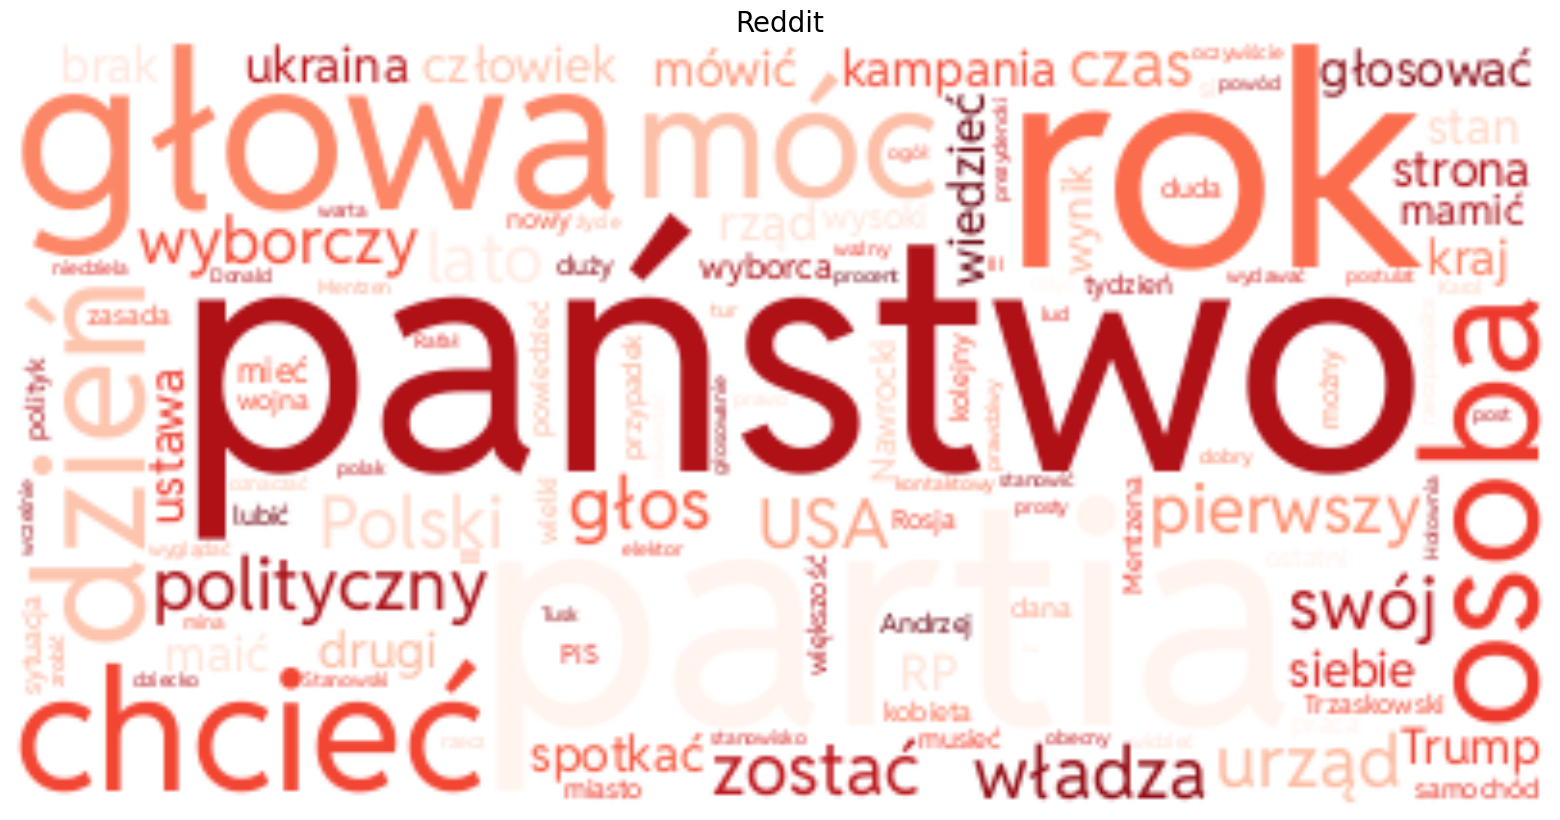

In [35]:
font_path = 'img/RedditSans.ttf'
wc = WordCloud(font_path = font_path,
               background_color = "white",
               colormap = "Reds",
               contour_width=5,
               contour_color='firebrick')
wc.generate_from_frequencies(filtered_word_freq)

plt.figure(figsize=[20,10])
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title('Reddit', fontsize=20)

plt.show()


## Analiza sentymentu

In [36]:
ramka_slow = ramka_slow.merge(
    slownik_sentymentu,
    left_on='lemma_clean', 
    right_on='lemat',
    how='left'
)